## Data Set Information:

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). 

Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

### original dataset from: https://archive.ics.uci.edu/ml/datasets/student+performance

In [1]:
import time
import os
import zipfile

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

# import sklearn

## Extract and laod Datasets

In [2]:
# extract and load dataset
DATASET_ZIP = 'Datasets/Students_Grades/student.zip'
DATASET_TARGET = 'student_grades'

def extract_dataset(source_dir=DATASET_ZIP, target_dir=DATASET_TARGET):
    # takes zip folder and unzips to target destination
    try:
        with zipfile.ZipFile(DATASET_ZIP,'r') as zip_ref:
            zip_ref.extractall(DATASET_TARGET)
    except IOError:
        print('rror: File does not appear to exist.')

def load_dataset(source_dir, dataset_name, sep=','):
    # loads csv data into pandas DataFrame
    csv_path = os.path.join(source_dir, dataset_name)
    return pd.read_csv(csv_path, sep)


In [3]:
# extract zip file
extract_dataset(DATASET_ZIP, DATASET_TARGET)
# load datasets into pandas
math_grades = load_dataset(source_dir='student_grades', dataset_name='student-mat.csv', sep=';')
por_grades = load_dataset(source_dir='student_grades', dataset_name='student-por.csv', sep=';')


In [4]:
math_grades.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:

<ol>
<li>school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)</li>  
<li>sex - student's sex (binary: 'F' - female or 'M' - male)</li>
<li>age - student's age (numeric: from 15 to 22)</li>
<li>address - student's home address type (binary: 'U' - urban or 'R' - rural)</li>
<li>famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)</li>
<li>Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)</li>
<li>Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)</li>
<li>Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)</li>
<li>Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')</li>
<li>Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')</li>
<li>reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')</li>
<li>guardian - student's guardian (nominal: 'mother', 'father' or 'other')</li>
<li>traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)</li>
<li>studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)</li>
<li>failures - number of past class failures (numeric: n if 1<=n<3, else 4)</li>
<li>schoolsup - extra educational support (binary: yes or no)</li>
<li>famsup - family educational support (binary: yes or no)</li>
<li>paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)</li>
<li>activities - extra-curricular activities (binary: yes or no)</li>
<li>nursery - attended nursery school (binary: yes or no)</li>
<li>higher - wants to take higher education (binary: yes or no)</li>
<li>internet - Internet access at home (binary: yes or no)</li>
<li>romantic - with a romantic relationship (binary: yes or no)</li>
<li>famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)</li>
<li>freetime - free time after school (numeric: from 1 - very low to 5 - very high)</li>
<li>goout - going out with friends (numeric: from 1 - very low to 5 - very high)</li>
<li>Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)</li>
<li>Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)</li>
<li>health - current health status (numeric: from 1 - very bad to 5 - very good)</li>
<li>absences - number of school absences (numeric: from 0 to 93)</li>
</ol>

# These grades are related with the course subject, Math or Portuguese:

<ul>
<li>31. G1 - first period grade (numeric: from 0 to 20)</li>
<li>31. G2 - second period grade (numeric: from 0 to 20)</li>
<li>32. G3 - final grade (numeric: from 0 to 20, output target)</li>
</ul>

In [5]:
# takeing a look at the datatypes
math_grades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       395 non-null object
famsize       395 non-null object
Pstatus       395 non-null object
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
schoolsup     395 non-null object
famsup        395 non-null object
paid          395 non-null object
activities    395 non-null object
nursery       395 non-null object
higher        395 non-null object
internet      395 non-null object
romantic      395 non-null object
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 non-null int64
Dalc          395 no

In [6]:
math_grades.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


## Data Exploration

In [7]:
# create a copy of the original dataset for data exploration
expl_math_grades = math_grades.copy()

# create grade avg column (could be helpful)
expl_math_grades['grade_avg'] = (expl_math_grades['G1'] +
                                 expl_math_grades['G2'] +
                                 expl_math_grades['G3'])/3

expl_math_grades['grade_avg_G12'] = (expl_math_grades['G1'] +
                                     expl_math_grades['G2'])/2


## Grades Distribution

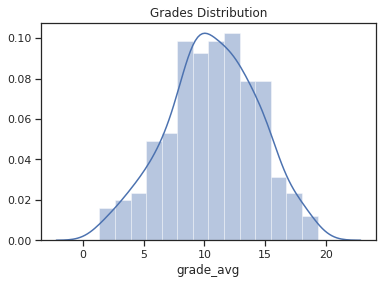

In [8]:
# grades are Gaussian distributed
sns.distplot(expl_math_grades['grade_avg']);
plt.title('Grades Distribution');

## School
#### school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)

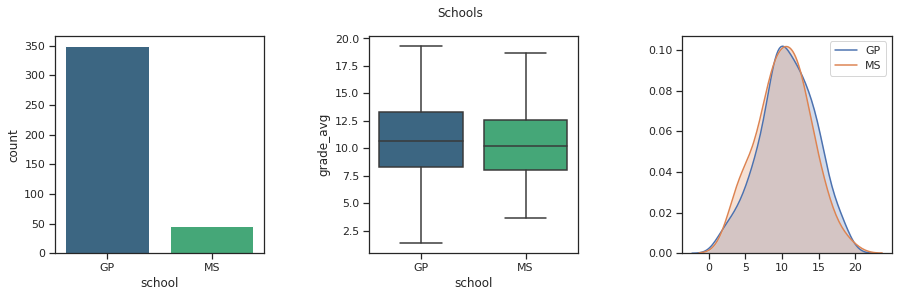

In [9]:
# create subplots to save some space
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Schools')

sns.countplot(expl_math_grades['school'], palette='viridis',ax=axs[0]);
sns.boxplot(x='school', y='grade_avg', data=expl_math_grades, palette='viridis', ax=axs[1]);

for school in (['GP', 'MS']):
    sns.kdeplot(expl_math_grades[(expl_math_grades['school']==school)]['grade_avg'],
                label=school, shade=True, ax=axs[2]);


### Age

Most students are around the age of 16 to 17 (age histogram slight right skew), according to the following graphs they tend to score a bit worse as they grow older.

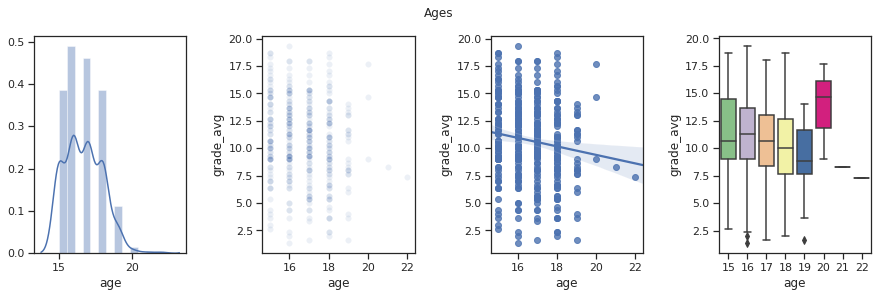

In [10]:
# create subplots to save some space
fig, axs = plt.subplots(ncols=4, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Ages')

# age histogram, slight right skew
sns.distplot(expl_math_grades['age'], ax=axs[0]);
sns.scatterplot(x='age', y='grade_avg', data=expl_math_grades, palette='Accent', alpha=0.1, ax=axs[1]);
sns.regplot(x='age', y='grade_avg', data=expl_math_grades, ax=axs[2]);
sns.boxplot(x='age', y='grade_avg', data=expl_math_grades, palette='Accent', ax=axs[3]);


## Gender

Males tend to score slightly higher on math class on average.

# Females:208
# Males:187


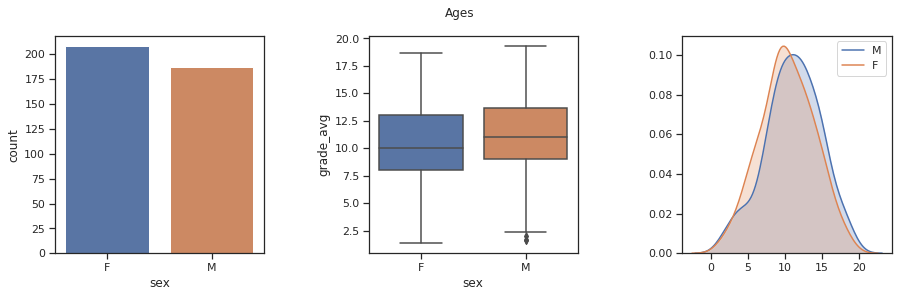

In [11]:
males = len(expl_math_grades[(expl_math_grades['sex']=='M')])
females = len(expl_math_grades[(expl_math_grades['sex']=='F')])

print(f'# Females:{females}\n# Males:{males}')

# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Ages')

# males tend to score slightly higher on math class on avg.
sns.countplot(expl_math_grades['sex'], ax=axs[0]);
sns.boxplot(x ='sex', y ='grade_avg', data = expl_math_grades, ax=axs[1]);

for sex in (['M', 'F']):
    sns.kdeplot(expl_math_grades[(expl_math_grades['sex']==sex)]['grade_avg'], label=sex, shade=True, ax=axs[2]);

## Address
Students comming from Urban areas tend to score  slightly higher on average but does not appear to be relevant.

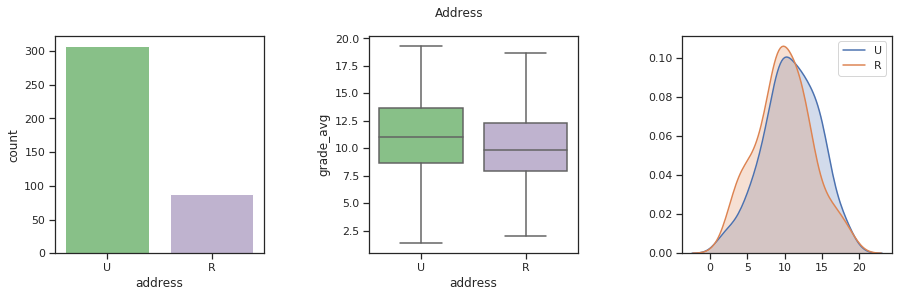

In [12]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Address')

# students from Urban areas tend to score  slightly higher on average
sns.countplot(expl_math_grades['address'], palette='Accent', ax=axs[0]);
sns.boxplot(x='address', y='grade_avg', data=expl_math_grades, palette='Accent', ax=axs[1]);

for adrs in (['U', 'R']):
    sns.kdeplot(expl_math_grades[(expl_math_grades['address']==adrs)]['grade_avg'],
                label=adrs, shade=True, ax=axs[2]);

## Family Size

Student with less than 3 members might score better, but does not seem relevant. 

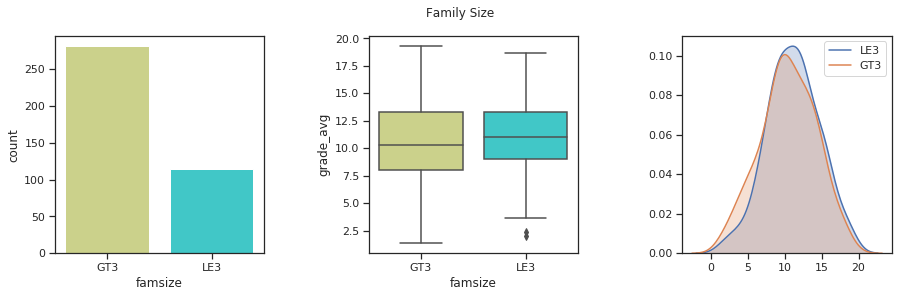

In [13]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Family Size')

# plots
sns.countplot(expl_math_grades['famsize'], palette='rainbow_r', ax=axs[0]);
sns.boxplot(x='famsize', y='grade_avg', data=expl_math_grades, palette='rainbow_r', ax=axs[1]);

for famsize in (['LE3', 'GT3']):
    sns.kdeplot(expl_math_grades[(expl_math_grades['famsize']==famsize)]['grade_avg'],
                label=famsize, shade=True, ax=axs[2]);

## Parent Marital Status

Parents living apart is unrepresented and contraty to own beliefs it does not seem to have any interesting effect on the student performance.

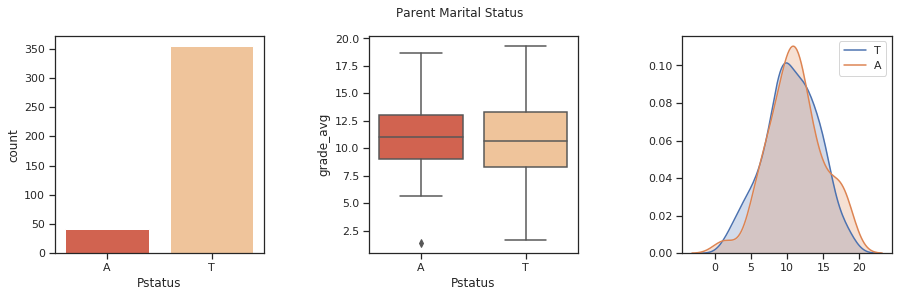

In [14]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Parent Marital Status')

# plots
sns.countplot(expl_math_grades['Pstatus'], palette='OrRd_r', ax=axs[0]);
sns.boxplot(x='Pstatus', y='grade_avg', data=expl_math_grades, palette='OrRd_r', ax=axs[1]);

for pstatus in (['T', 'A']):
    sns.kdeplot(expl_math_grades[(expl_math_grades['Pstatus']==pstatus)]['grade_avg'],
                label=pstatus, shade=True, ax=axs[2]);

## Study Time

Students who put more time into study tend to get slightly better grades. However, there does not seem to be many students actually studying much... or even beyond 4 hours a week.

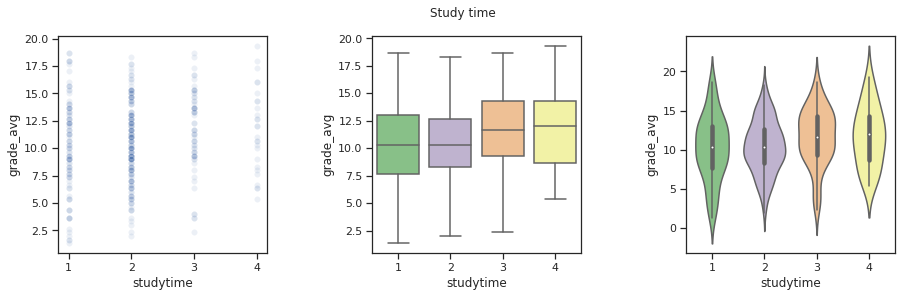

In [15]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Study time')

# there is a slight trend upwards
sns.scatterplot(x='studytime', y='grade_avg', data=expl_math_grades, palette='Accent', alpha=0.1, ax=axs[0]);
sns.boxplot(x='studytime', y='grade_avg', data=expl_math_grades, palette='Accent', ax=axs[1]);
sns.violinplot(x='studytime', y='grade_avg', data=expl_math_grades, palette='Accent', ax=axs[2]);

## Parents Education
<ul>
<li>Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2:5th to 9th grade, 3:secondary education or 4:higher education</li>
<li>Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2:5th to 9th grade, 3:secondary education or 4:higher education)</li>
</ul>

As paretns have more education, the students tend to score higher.

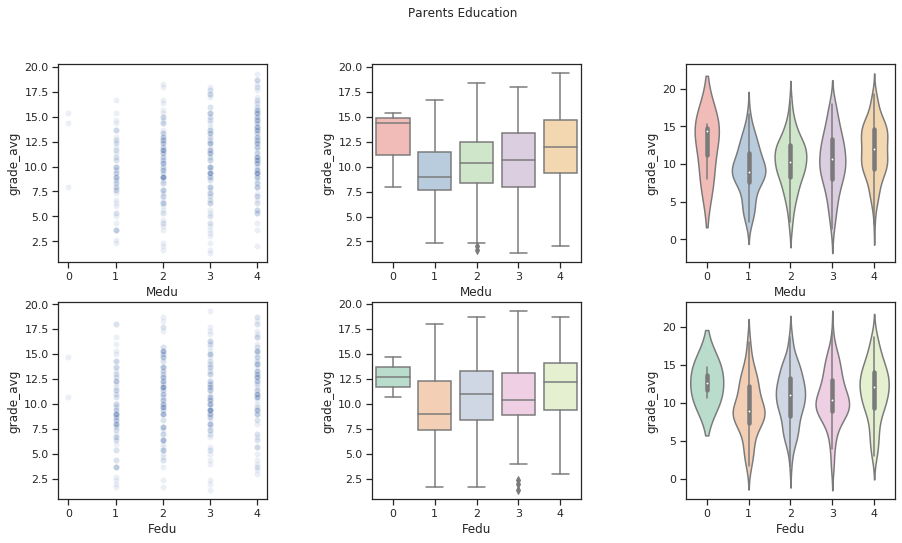

In [16]:
# create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Parents Education')

# mother education, there is a slight trend upwards
sns.scatterplot(x='Medu', y='grade_avg', data=expl_math_grades, alpha=0.1, ax=axs[0][0]);
sns.boxplot(x='Medu', y='grade_avg', data=expl_math_grades, palette='Pastel1', ax=axs[0][1]);
sns.violinplot(x='Medu', y='grade_avg', data=expl_math_grades, palette='Pastel1', ax=axs[0][2]);

# father education, there is a slight trend upwards
sns.scatterplot(x='Fedu', y='grade_avg', data=expl_math_grades, alpha=0.1, ax=axs[1][0]);
sns.boxplot(x='Fedu', y='grade_avg', data=expl_math_grades, palette='Pastel2', ax=axs[1][1]);
sns.violinplot(x='Fedu', y='grade_avg', data=expl_math_grades, palette='Pastel2', ax=axs[1][2]);

### Parents job

Most parents fall into the "other", however stundents having a teacher father or mother working in services tend to score better.

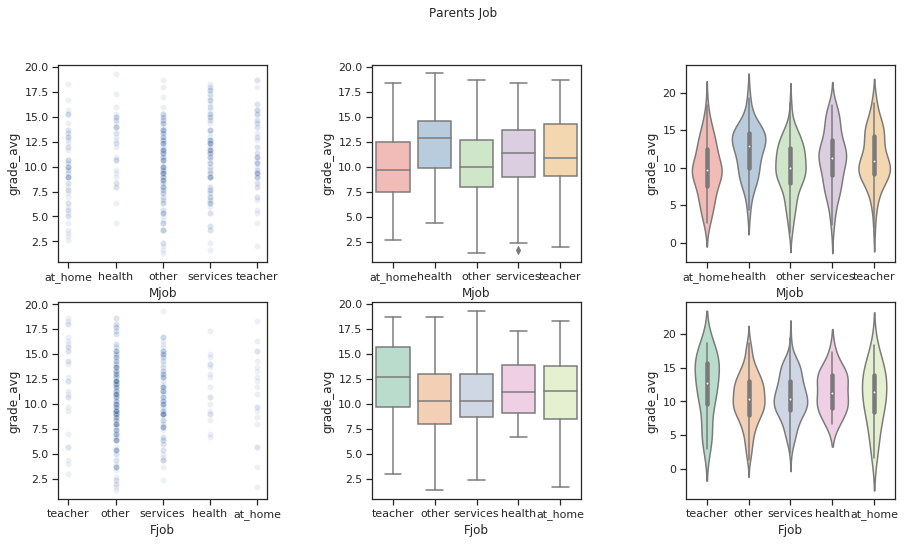

In [17]:
# create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Parents Job')

# mother job
sns.scatterplot(x='Mjob', y='grade_avg', data=expl_math_grades, alpha=0.1, ax=axs[0][0]);
sns.boxplot(x='Mjob', y='grade_avg', data=expl_math_grades, palette='Pastel1', ax=axs[0][1]);
sns.violinplot(x='Mjob', y='grade_avg', data=expl_math_grades, palette='Pastel1', ax=axs[0][2]);
# father job
sns.scatterplot(x='Fjob', y='grade_avg', data=expl_math_grades, alpha=0.1, ax=axs[1][0]);
sns.boxplot(x='Fjob', y='grade_avg', data=expl_math_grades, palette='Pastel2', ax=axs[1][1]);
sns.violinplot(x='Fjob', y='grade_avg', data=expl_math_grades, palette='Pastel2', ax=axs[1][2]);


### Reason to study

<ul>
<li>reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')</li>
</ul>

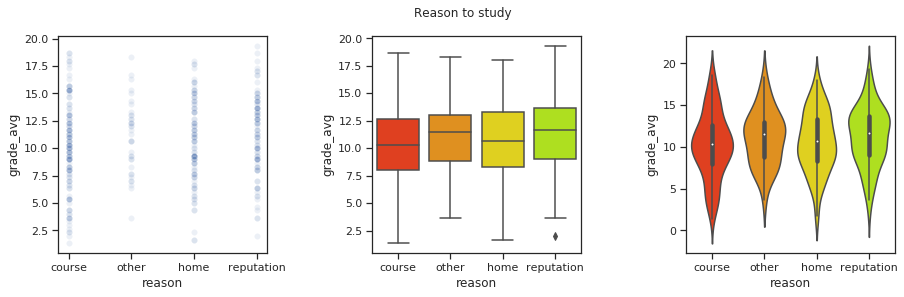

In [18]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Reason to study')

# mother job
sns.scatterplot(x='reason', y='grade_avg', data=expl_math_grades, alpha=0.1, ax=axs[0]);
sns.boxplot(x='reason', y='grade_avg', data=expl_math_grades, palette='prism', ax=axs[1]);
sns.violinplot(x='reason', y='grade_avg', data=expl_math_grades, palette='prism', ax=axs[2]);

### Guardian

<ul>
<li>guardian - student's guardian (nominal: 'mother', 'father' or 'other')</li>
</ul>

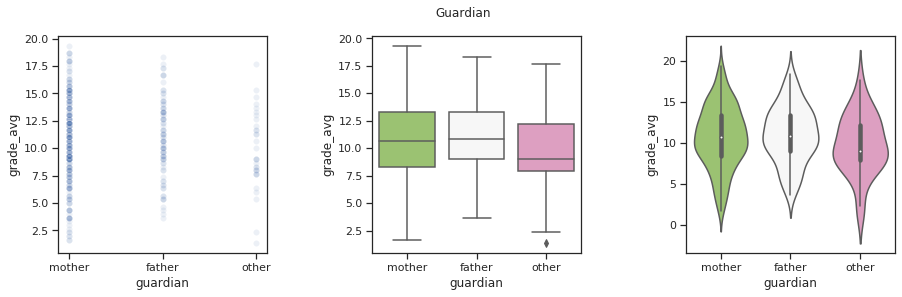

In [19]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Guardian')

# mother job
sns.scatterplot(x='guardian', y='grade_avg', data=expl_math_grades, alpha=0.1, ax=axs[0]);
sns.boxplot(x='guardian', y='grade_avg', data=expl_math_grades, palette='PiYG_r', ax=axs[1]);
sns.violinplot(x='guardian', y='grade_avg', data=expl_math_grades, palette='PiYG_r', ax=axs[2]);

### Travel Time

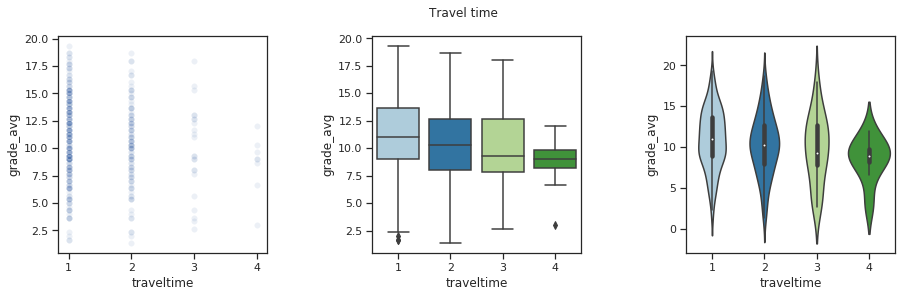

In [20]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Travel time')

# mother job
sns.scatterplot(x='traveltime', y='grade_avg', data=expl_math_grades, alpha=0.1, ax=axs[0]);
sns.boxplot(x='traveltime', y='grade_avg', data=expl_math_grades, palette='Paired', ax=axs[1]);
sns.violinplot(x='traveltime', y='grade_avg', data=expl_math_grades, palette='Paired', ax=axs[2]);

### Failures

Clear trend downwards

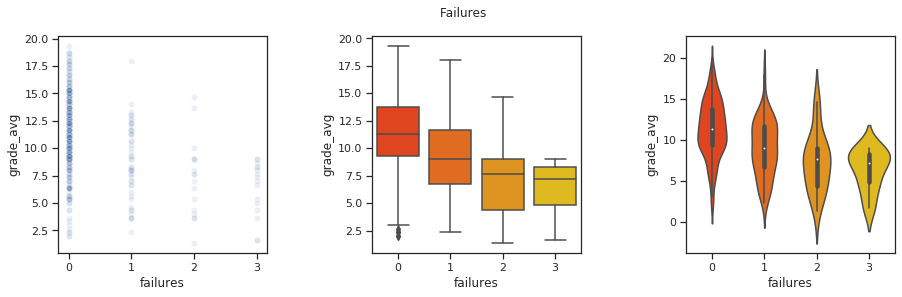

In [21]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Failures')

# mother job
sns.scatterplot(x='failures', y='grade_avg', data=expl_math_grades, alpha=0.1, ax=axs[0]);
sns.boxplot(x='failures', y='grade_avg', data=expl_math_grades, palette='autumn', ax=axs[1]);
sns.violinplot(x='failures', y='grade_avg', data=expl_math_grades, palette='autumn', ax=axs[2]);

### Extra education

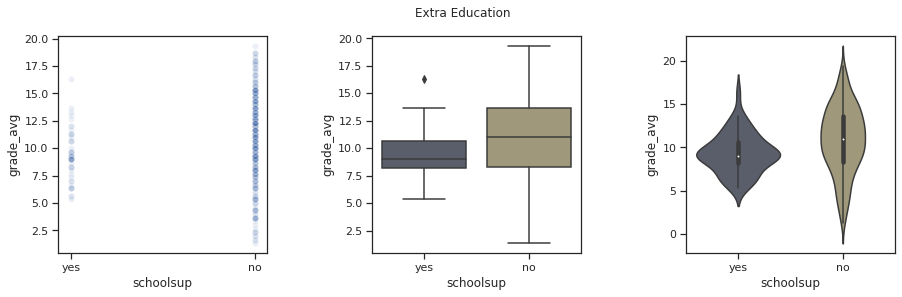

In [22]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Extra Education')

# mother job
sns.scatterplot(x='schoolsup', y='grade_avg', data=expl_math_grades, alpha=0.1, ax=axs[0]);
sns.boxplot(x='schoolsup', y='grade_avg', data=expl_math_grades, palette='cividis', ax=axs[1]);
sns.violinplot(x='schoolsup', y='grade_avg', data=expl_math_grades, palette='cividis', ax=axs[2]);

### Family educational support 
(binary: yes or no)

In [23]:
## work in progress